In [15]:
# Basic imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [17]:
# Configuration - adjust these paths to match your environment
ROOT_DIR = "Major/pavement_data"  # Change this if your path is different
CLASSES = ["cracks", "potholes", "bleeding"]
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 16  # Smaller batch size to avoid memory issues
EPOCHS = 15

In [19]:
# Basic imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Configuration - adjust these paths to match your environment
ROOT_DIR = "Major/pavement_data"  # Change this if your path is different
CLASSES = ["cracks", "potholes", "bleeding"]
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 16  # Smaller batch size to avoid memory issues
EPOCHS = 15

# Step 1: Create and split dataset
print("Creating dataset...")
rows = []
for cls in CLASSES:
    cls_dir = os.path.join(ROOT_DIR, cls)
    if not os.path.exists(cls_dir):
        print(f"Warning: Directory {cls_dir} does not exist!")
        continue
        
    print(f"Processing {cls}...")
    for fname in os.listdir(cls_dir):
        if fname.lower().endswith((".jpg", ".png")):
            rows.append({
                "filepath": os.path.join(cls_dir, fname),
                "label": cls
            })

# Check if we found any images
if not rows:
    print("No images found! Please check your directory path.")
    raise Exception("No images found in the specified directories")

# Create and split dataframe
df = pd.DataFrame(rows)
print(f"Found {len(df)} images in total")

# Distribution of classes
class_counts = df['label'].value_counts()
print("Class distribution:")
for cls, count in class_counts.items():
    print(f"{cls}: {count} images")

# Shuffle and split
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
train = df.sample(frac=0.8, random_state=42)
valid = df.drop(train.index)

# Save to CSV (optional)
train_csv = "train_labels.csv"
valid_csv = "valid_labels.csv"
train.to_csv(train_csv, index=False)
valid.to_csv(valid_csv, index=False)
print(f"Train: {len(train)}, Validation: {len(valid)}")

Creating dataset...
Processing cracks...
Processing potholes...
Processing bleeding...
Found 1394 images in total
Class distribution:
potholes: 665 images
cracks: 629 images
bleeding: 100 images
Train: 1115, Validation: 279


In [21]:
# Step 2: Create data generators
print("Creating data generators...")
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
)

valid_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train,
    x_col="filepath",
    y_col="label",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
)

valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=valid,
    x_col="filepath",
    y_col="label",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
)

Creating data generators...
Found 1115 validated image filenames belonging to 3 classes.
Found 279 validated image filenames belonging to 3 classes.


In [23]:
# Step 3: Create a simpler model (MobileNetV2 instead of EfficientNet)
print("Building model...")
# Use MobileNetV2 which is included in Keras
base_model = MobileNetV2(
    weights="imagenet", 
    include_top=False, 
    input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)
)

Building model...
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [25]:
# Add custom top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
output = Dense(len(CLASSES), activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=output)

In [29]:
# Freeze base model
for layer in base_model.layers:
    layer.trainable = False

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [31]:
# Print model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,261,827 (8.63 MB)

 Trainable params: 3,843 (15.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [35]:
# Step 4: Train model
print("Training model...")
# Callbacks - Fix: Change file extension from .h5 to .keras
checkpoint = ModelCheckpoint(
    "best_model.keras",  # Changed from .h5 to .keras
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Train
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=EPOCHS,
    callbacks=[checkpoint, early_stopping]
)

Training model...
Epoch 1/15


/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step - accuracy: 0.6076 - loss: 1.0337
Epoch 1: val_accuracy improved from -inf to 0.95341, saving model to best_model.keras
70/70 ━━━━━━━━━━━━━━━━━━━━ 35s 436ms/step - accuracy: 0.6096 - loss: 1.0286 - val_accuracy: 0.9534 - val_loss: 0.1654
Epoch 2/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - accuracy: 0.9158 - loss: 0.2514
Epoch 2: val_accuracy did not improve from 0.95341
70/70 ━━━━━━━━━━━━━━━━━━━━ 30s 399ms/step - accuracy: 0.9159 - loss: 0.2510 - val_accuracy: 0.9534 - val_loss: 0.1129
Epoch 3/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - accuracy: 0.9378 - loss: 0.1801
Epoch 3: val_accuracy improved from 0.95341 to 0.96416, saving model to best_model.keras
70/70 ━━━━━━━━━━━━━━━━━━━━ 30s 397ms/step - accuracy: 0.9380 - loss: 0.1798 - val_accuracy: 0.9642 - val_loss: 0.0903
Epoch 4/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - accuracy: 0.9559 - loss: 0.1389
Epoch 4: val_accuracy improved from 0.96416 to 0.97133, saving model to best_model.kera

Plotting results...


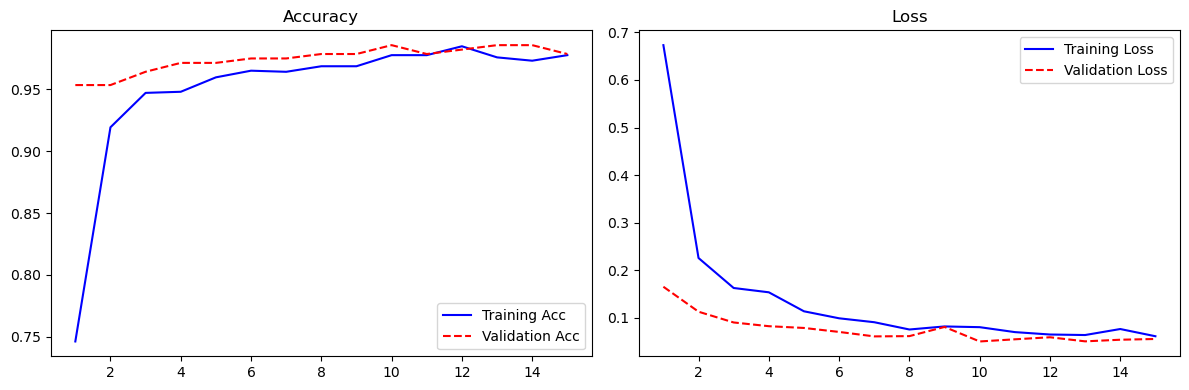

In [37]:
# Step 5: Plot results
print("Plotting results...")
acc = history.history.get("accuracy", [])
val_acc = history.history.get("val_accuracy", [])
loss = history.history.get("loss", [])
val_loss = history.history.get("val_loss", [])
epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, "b-", label="Training Acc")
plt.plot(epochs_range, val_acc, "r--", label="Validation Acc")
plt.title("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, "b-", label="Training Loss")
plt.plot(epochs_range, val_loss, "r--", label="Validation Loss")
plt.title("Loss")
plt.legend()
plt.tight_layout()
plt.savefig("training_history.png")
plt.show()

In [39]:
# Step 6: Evaluate on validation set
evaluation = model.evaluate(valid_generator)
print(f"Validation Loss: {evaluation[0]:.4f}")
print(f"Validation Accuracy: {evaluation[1]:.4f}")

18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 220ms/step - accuracy: 0.9859 - loss: 0.0487
Validation Loss: 0.0503
Validation Accuracy: 0.9857


In [41]:
# Step 7: Function to make predictions on new images
def predict_image(image_path):
    from tensorflow.keras.preprocessing import image
    import numpy as np
    
    img = image.load_img(image_path, target_size=IMAGE_SIZE)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0
    
    prediction = model.predict(img_array)
    predicted_class = CLASSES[np.argmax(prediction)]
    confidence = np.max(prediction)
    
    print(f"Predicted class: {predicted_class}")
    print(f"Confidence: {confidence:.2f}")
    
    # Display the image
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_class} ({confidence:.2f})")
    plt.axis('off')
    plt.show()
    
    return predicted_class, confidence

print("\nModel training complete! Use predict_image(path) to classify new images.")


Model training complete! Use predict_image(path) to classify new images.
